In [4]:
import numpy as np
import pandas as pd
import os
import math
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

In [5]:
# this function should be applied to a df containing the data for matches (aggregated or not) in the initial 
# clean format that we defined
# THIS FUNCTION ORDERS DISTANCES AND CLUSTERS FROM HIGHGEST TO LOWEST
def aggData(df):
    distances = df.iloc[:, 6:12]
    distances.fillna(-999)
    centroids = df.iloc[:, 12:16]
    centroids.fillna(-999)
    clusters = df.iloc[:, 16:20].values
    new_distances = np.sort(distances.values, axis=1)[:,::-1]
    new_centroids = np.sort(centroids.values, axis=1)[:,::-1]
    new_clusters = np.sort(clusters, axis=1)[:,::-1]
    distances = distances.replace(-999, np.nan)
    centroids = centroids.replace(-999, np.nan)
    df.iloc[:, 6:12] = new_distances
    df.iloc[:, 12:16] = new_centroids
    df.iloc[:, 16:20] = new_clusters
    df['agility']=np.where(df['strategy']!=df['strategy'].shift(-1), 1,0)
    ranking = df['ranking']
    df = df.drop('ranking', axis=1)
    df.insert(len(df.columns), 'ranking', ranking)
    df['cluster_A'] = df['cluster_A'] / df['n_alive']
    df['cluster_B'] = df['cluster_B'] / df['n_alive']
    df['cluster_C'] = df['cluster_C'] / df['n_alive']
    df['cluster_D'] = df['cluster_D'] / df['n_alive']
    df = df[df.n_alive > 0]
    df = df.drop(['time','n_alive','in_aircraft'], axis=1)
    df.loc[:,['distance1_2','distance1_3','distance1_4','distance2_3', 'distance2_4', 'distance3_4',
              'distance_centroid1', 'distance_centroid2', 'distance_centroid3', 'distance_centroid4']] = df.loc[:,['distance1_2','distance1_3','distance1_4','distance2_3', 'distance2_4', 'distance3_4',
                                                                                                                   'distance_centroid1', 'distance_centroid2', 'distance_centroid3', 'distance_centroid4']] / 100
    df.loc[:, ['distance1_2','distance1_3','distance1_4','distance2_3', 'distance2_4', 'distance3_4',
              'distance_centroid1', 'distance_centroid2', 'distance_centroid3', 'distance_centroid4']] = df.loc[:, ['distance1_2','distance1_3','distance1_4','distance2_3', 'distance2_4', 'distance3_4',
                                                                                                                   'distance_centroid1', 'distance_centroid2', 'distance_centroid3', 'distance_centroid4']].applymap(lambda x:np.log(x) if x != 0 else 0)
    means = df.groupby(['matchId', 'teamId']).mean().reset_index()
    stds = df.groupby(['matchId', 'teamId']).std().reset_index()
    means = means.fillna(99)
    means = means.replace(np.inf, 0)
    stds = stds.fillna(0)
    new_df = pd.merge(stds, means, how = 'left', on=['matchId', 'teamId'])
    new_df = new_df.drop(['n_players_x', 'ranking_x', 'agility_x'], axis=1)
    return new_df

In [6]:
df = pd.read_csv('combined_csv_1.csv')
aggregated_df = aggData(df)
df3 = pd.read_csv('combined_csv_4.csv')
aggregated_df3 = aggData(df3)
df2 = pd.read_csv('combined_csv_2.csv')
aggregated_df2 = aggData(df2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


In [7]:
df_123 = pd.concat([aggregated_df, aggregated_df2,aggregated_df3],ignore_index=True)

## Linear Regression

In [58]:
copy_df=df_123.copy()
copy1_df=df_123.copy()
x_df=df_123.drop(["ranking_y"],axis=1)
y_df=copy_df["ranking_y"]
X_df=x_df.iloc[:,1:]

X_df=sm.add_constant(X_df)
model = sm.OLS(y_df,X_df.astype(float)).fit()

model.summary()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ranking_y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     1659.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:56:01   Log-Likelihood:            -3.8617e+05
No. Observations:              116478   AIC:                         7.724e+05
Df Residuals:                  116446   BIC:                         7.727e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -197.1042     24.374     -8.087      0.000    -244.878    -149.331
teamId                   0.0906      0.003     35.936      0.000       0.086       0.096
distance1_2_x           -1.1029      0.104    -10.592      0.000      -1.307      -0.899
distance1_3_x           -0.0682      0.125     -0.544      0.587      -0.314       0.178
distance1_4_x            0.3344      0.080      4.173      0.000       0.177       0.491
distance2_3_x            0.6773      0.098      6.914      0.000       0.485       0.869
distance2_4_x           -1.2316      0.110    -11.170      0.000      -1.448      -1.015
distance3_4_x            0.3712      0.076      4.903      0.000       0.223       0.520
distance_centroid1_x     3.4789      0.044     79.137      0.000       3.393       3.565
distance_centroid2_x     1.1826      0.084     14.139      0.000       1.019       1.346
distance_centroid3_x    -1.3528      0.090    -14.957      0.000      -1.530      -1.176
distance_centroid4_x     1.3790      0.059     23.341      0.000       1.263       1.495
cluster_A_x             11.6535      1.584      7.359      0.000       8.550      14.757
cluster_B_x            -53.5794      1.724    -31.087      0.000     -56.957     -50.201
cluster_C_x            -35.1410      1.444    -24.334      0.000     -37.971     -32.311
cluster_D_x            -33.8434      1.728    -19.587      0.000     -37.230     -30.457
n_players_y             -0.1873      0.140     -1.340      0.180      -0.461       0.087
distance1_2_y            0.0853      0.004     23.282      0.000       0.078       0.092
distance1_3_y            0.0195      0.010      2.049      0.040       0.001       0.038
distance1_4_y           -0.0081      0.009     -0.880      0.379      -0.026       0.010
distance2_3_y            0.0314      0.003      9.620      0.000       0.025       0.038
distance2_4_y            0.0389      0.004      9.535      0.000       0.031       0.047
distance3_4_y            0.0144      0.003      5.188      0.000       0.009       0.020
distance_centroid1_y    -0.0248      0.003     -7.460      0.000      -0.031      -0.018
distance_centroid2_y    -0.0119      0.003     -4.565      0.000      -0.017      -0.007
distance_centroid3_y     0.0063      0.002      2.728      0.006       0.002       0.011
distance_centroid4_y    -0.0143      0.002     -6.809      0.000      -0.018      -0.010
cluster_A_y            200.1053     24.200      8.269      0.000     152.674     247.537
cluster_B_y            219.0014     24.216      9.044      0.000     171.538     266.465
cluster_C_y            216.0048     24.263      8.903      0.000     168.450     263.560
cluster_D_y            228.0829     24.325      9.377      0.000     180.407     275.759
agility_y               31.5231      0.186    169.918    

In [48]:
# calc rmse
y_pred = model.predict(X_df)
rms = sqrt(mean_squared_error(y_df, y_pred))
rms

In [67]:
reg1=x_df.iloc[:, np.r_[2:16,31]]

In [68]:
X_reg=sm.add_constant(reg1)
model = sm.OLS(y_df,X_reg.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ranking_y   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1859.
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:29:41   Log-Likelihood:            -3.9498e+05
No. Observations:              116478   AIC:                         7.900e+05
Df Residuals:                  116462   BIC:                         7.901e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   16.0824      0.060    269.278      0.000      15.965      16.199
distance1_2_x           -1.6596      0.094    -17.574      0.000      -1.845      -1.475
distance1_3_x           -3.2666      0.126    -25.861      0.000      -3.514      -3.019
distance1_4_x           -0.6948      0.083     -8.345      0.000      -0.858      -0.532
distance2_3_x           -0.6533      0.099     -6.628      0.000      -0.846      -0.460
distance2_4_x           -1.9461      0.114    -17.047      0.000      -2.170      -1.722
distance3_4_x           -1.7387      0.070    -24.695      0.000      -1.877      -1.601
distance_centroid1_x     2.1756      0.043     50.973      0.000       2.092       2.259
distance_centroid2_x     0.3351      0.066      5.047      0.000       0.205       0.465
distance_centroid3_x     1.1267      0.081     13.919      0.000       0.968       1.285
distance_centroid4_x     0.7622      0.058     13.054      0.000       0.648       0.877
cluster_A_x             -0.8601      1.369     -0.628      0.530      -3.543       1.823
cluster_B_x            -32.1937      1.281    -25.128      0.000     -34.705     -29.683
cluster_C_x              3.6201      1.100      3.292      0.001       1.465       5.775
cluster_D_x             13.1718      1.230     10.707      0.000      10.761      15.583
agility_y               22.3010      0.178    125.179      0.000      21.952      22.650
==============================================================================
Omnibus:                      977.498   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.655
Skew:                           0.219   Prob(JB):                    1.55e-219
Kurtosis:                       3.127   Cond. No.                         353.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Linear Regression with scikit-learn

In [18]:
kfold=KFold(n_splits=10, random_state=7)

model=LinearRegression()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_df, y_df, cv=kfold, scoring=scoring)

print(f'Linear Regression - MSE {results.mean():.3f} std {results.std():.3f}')

# Create the DataFrames for plotting
resall=pd.DataFrame()
res_w1=pd.DataFrame()

res_w1["Res"]=results
res_w1["Type"]="Lin"

resall=pd.concat([resall,res_w1], ignore_index=True)

# Now lets use it in the same way than the statsmodel

model_x=LinearRegression()
model_x.fit(X_df,y_df)
print(f'Intercept {model_x.intercept_:.4f}')
print("Coefficients ",model_x.coef_)

y_pred_x=model_x.predict(X_df)

print(f'MAE - Mean Absolute Error {mean_absolute_error(y_df, y_pred_x):.3f}')
print(f'MSE - Mean Square Error  {mean_squared_error(y_df, y_pred_x):.3f}')
print(f'R2    {r2_score(y_df, y_pred_x):.3f}')

Linear Regression - MSE -44.442 std 0.520
Intercept -197.1042
Coefficients  [ 2.41785771e-11  9.05772917e-02 -1.10287911e+00 -6.81508352e-02
  3.34350140e-01  6.77269068e-01 -1.23155499e+00  3.71153765e-01
  3.47890138e+00  1.18255153e+00 -1.35278847e+00  1.37902391e+00
  1.16535398e+01 -5.35793649e+01 -3.51409862e+01 -3.38434173e+01
 -1.87281618e-01  8.52763677e-02  1.95044534e-02 -8.09742586e-03
  3.13891608e-02  3.89093885e-02  1.43718595e-02 -2.47688685e-02
 -1.19171589e-02  6.25005567e-03 -1.43237491e-02  2.00105338e+02
  2.19001386e+02  2.16004840e+02  2.28082881e+02  3.15231429e+01]
MAE - Mean Absolute Error 5.490
MSE - Mean Square Error  44.387
R2    0.306


# Ridge Regression 

In [19]:
kfold=KFold(n_splits=10, random_state=7)

model=Ridge()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_df, y_df, cv=kfold, scoring=scoring)

print(f'Ridge Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="Ridge"

resall=pd.concat([resall,res_w1], ignore_index=True)

Ridge Regression - MSE -44.459 std 0.527


# Lasso Regression 

In [20]:
kfold=KFold(n_splits=10, random_state=7)

model=Lasso()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_df, y_df, cv=kfold, scoring=scoring)

print(f'Lasso Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="Lasso"

resall=pd.concat([resall,res_w1], ignore_index=True)

Lasso Regression - MSE -58.409 std 0.792


In [27]:
# Scale between 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
X_sc=scaler.fit_transform(X_df)

# KNN Regression 

In [28]:
kfold=KFold(n_splits=10, random_state=7)

model=KNeighborsRegressor()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_sc, y_df, cv=kfold, scoring=scoring)

print(f'KNN Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="KNN"

resall=pd.concat([resall,res_w1], ignore_index=True)

KNN Regression - MSE -42.643 std 0.517


# Decision Trees Regression

In [29]:
kfold=KFold(n_splits=10, random_state=7)

model=DecisionTreeRegressor()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_sc, y_df, cv=kfold, scoring=scoring)

print(f'Decision Trees Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="Trees"

resall=pd.concat([resall,res_w1], ignore_index=True)

Decision Trees Regression - MSE -63.283 std 0.819


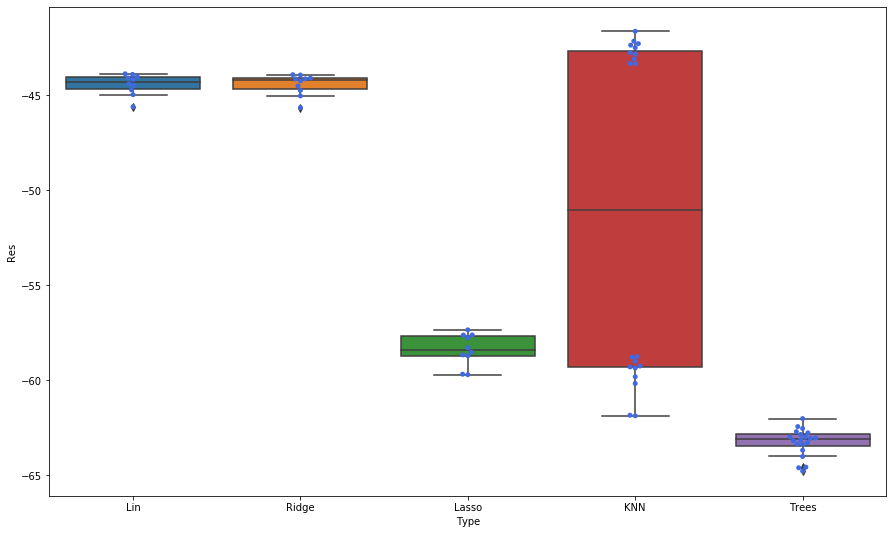

In [30]:
# Now let's compare them all 
plt.figure(figsize=(15,9))

sns.boxplot(data=resall, x="Type", y="Res")

sns.swarmplot(data=resall, x="Type", y="Res", color="royalblue")

In [44]:
copy_df['in Top 5']=np.where(copy_df['ranking_y']<=5, 'yes','no')

In [46]:
x_df=copy_df.drop(["ranking_y",'in Top 5'],axis=1)
y_df=copy_df['in Top 5']
X_df=x_df.iloc[:,1:]

In [50]:
from sklearn import preprocessing
std_scaler=preprocessing.StandardScaler()
X_std=std_scaler.fit_transform(X_df)

In [52]:
res_w1=pd.DataFrame()
res_w2=pd.DataFrame()

In [53]:
# Logistic Regression

kfold=KFold(n_splits=10, random_state=7)

model=LogisticRegression(solver="liblinear")

results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'Logistic Regression - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'Logistic Regression (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')


# if the range of variables is large scaling doesn't matter in a log regression 
# but if you are not sure if they are (or you don't want to check ... ) just try ! 

res_w1["Res"]=results
res_w1["Type"]="log"

res_w2["Res"]=results_scl
res_w2["Type"]="log -1..1"


resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Logistic Regression - Accuracy 79.178% std 0.220369
Logistic Regression (-1..1) - Accuracy 79.084% std 0.242774


In [54]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

kfold=KFold(n_splits=10, random_state=7)

model=GaussianNB()

results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'Naive Bayes - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'Naive Bayes (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')

res_w1["Res"]=results
res_w1["Type"]="NB"

res_w2["Res"]=results_scl
res_w2["Type"]="NB -1..1"

resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)

Naive Bayes - Accuracy 47.114% std 0.352504
Naive Bayes (-1..1) - Accuracy 47.129% std 0.355343


In [55]:
# Decision Trees

from sklearn.tree import DecisionTreeClassifier

seed=7

kfold=KFold(n_splits=10, random_state=seed)

model=DecisionTreeClassifier(class_weight="balanced", random_state=seed)


results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'Decision Tree - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'Decision Tree (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')


res_w1["Res"]=results
res_w1["Type"]="DT"

res_w2["Res"]=results_scl
res_w2["Type"]="DT -1..1"

resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)

Decision Tree - Accuracy 75.526% std 0.299363
Decision Tree (-1..1) - Accuracy 75.540% std 0.279513


In [56]:
# LDA - Linear Discriminant Analysis               ##!!!!!!!!!!!!!!!! y L 3ADE AKHADD!!!!!!!!! y y y 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

kfold=KFold(n_splits=10, random_state=7)

model=LinearDiscriminantAnalysis()

results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'LDA Linear Discriminant Analysis - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'LDA (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')


res_w1["Res"]=results
res_w1["Type"]="LDA"

res_w2["Res"]=results_scl
res_w2["Type"]="LDA -1..1"

resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)


LDA Linear Discriminant Analysis - Accuracy 79.212% std 0.209158
LDA (-1..1) - Accuracy 79.212% std 0.209158


# Top 3

In [59]:
copy_df['in Top 3']=np.where(copy_df['ranking_y']<=3, 'yes','no')
x_df=copy_df.drop(["ranking_y",'in Top 3'],axis=1)
y_df=copy_df['in Top 3']
X_df=x_df.iloc[:,1:]
std_scaler=preprocessing.StandardScaler()
X_std=std_scaler.fit_transform(X_df)

In [60]:
res_w1=pd.DataFrame()
res_w2=pd.DataFrame()

In [65]:
# Logistic Regression

kfold=KFold(n_splits=10, random_state=7)

model=LogisticRegression(solver="liblinear",class_weight="balanced")

results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'Logistic Regression - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'Logistic Regression (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')

res_w1["Res"]=results
res_w1["Type"]="log"

res_w2["Res"]=results_scl
res_w2["Type"]="log -1..1"


resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Logistic Regression - Accuracy 63.112% std 0.463581
Logistic Regression (-1..1) - Accuracy 66.953% std 0.293536


In [62]:
# Decision Trees
seed=7

kfold=KFold(n_splits=10, random_state=seed)

model=DecisionTreeClassifier(class_weight="balanced", random_state=seed)


results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'Decision Tree - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'Decision Tree (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')


res_w1["Res"]=results
res_w1["Type"]="DT"

res_w2["Res"]=results_scl
res_w2["Type"]="DT -1..1"

resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)

Decision Tree - Accuracy 82.617% std 0.307360
Decision Tree (-1..1) - Accuracy 82.633% std 0.342758


In [63]:
# LDA - Linear Discriminant Analysis

kfold=KFold(n_splits=10, random_state=7)

model=LinearDiscriminantAnalysis()

results=cross_val_score(model, X_df, y_df, cv=kfold)

print(f'LDA Linear Discriminant Analysis - Accuracy {results.mean()*100:.3f}% std {results.std()*100:3f}')

results_scl=cross_val_score(model, X_std, y_df, cv=kfold)

print(f'LDA (-1..1) - Accuracy {results_scl.mean()*100:.3f}% std {results_scl.std()*100:3f}')


res_w1["Res"]=results
res_w1["Type"]="LDA"

res_w2["Res"]=results_scl
res_w2["Type"]="LDA -1..1"

resall=pd.concat([resall,res_w1,res_w2], ignore_index=True)



LDA Linear Discriminant Analysis - Accuracy 87.452% std 0.073271
LDA (-1..1) - Accuracy 87.452% std 0.073271
